In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from glob import glob
import seaborn as sns

from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.stats import linregress


def IOA_Loss_np(o, p):
    ioa = 1 - (np.sum((o - p) ** 2)) / (
        np.sum((np.abs(p - np.mean(o)) + np.abs(o - np.mean(o))) ** 2)
    )
    return ioa


In [2]:

def plot_scatter_with_fit(ax, x, y, xlabel, ylabel, title, fig=None, metrics=None, var=None, xmax=None, ymax=None):
    """
    Creates an enhanced hexbin scatter plot with regression line and statistics.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axes to plot on
    x, y : array-like
        Data to plot
    xlabel, ylabel : str
        Labels for axes
    title : str
        Plot title
    fig : matplotlib.figure.Figure
        Figure object for colorbar reference
    metrics : dict
        Dictionary containing statistical metrics
    var : str
        Variable name for metrics lookup ('model' or 'tempo')
    """
    # Extract metrics with safety checks
    mab = metrics.get(f'mab_{var}', 0)
    rmse = metrics.get(f'rmse_{var}', 0)
    IOA = metrics.get(f'ioa_{var}', 0)
    
    # Set up the hexbin plot with improved colors
    ax.set_aspect('equal')
    
    # Create hexbin with enhanced visuals
    hb = ax.hexbin(x, y, gridsize=150, cmap='turbo', 
                  norm=colors.LogNorm(vmin=1, vmax=None), 
                  mincnt=1, alpha=0.95, linewidths=0)
    
    # Add identity line (1:1)
    # max_value = max(max(x), max(y))  # Add 5% margin
    max_value = max(x) + 0.25 * max(x)  # Add 5% margin
    # max_value = 1.05e17
    ax.plot([0, max_value], [0, max_value], linestyle='--', color='gray', 
            linewidth=1.5, alpha=0.8, label='1:1 Line')
    
    # Calculate and add regression line
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    x_line = np.linspace(0, max_value, 100)
    ax.plot(x_line, slope * x_line + intercept, color='#d62728', 
            linewidth=2, label=f'Fit (y = {slope:.2f}x + {intercept:.2e})')
    
    # Set axis limits with margin
    ax.set_xlim([0, max_value])
    ax.set_ylim([0, max_value])
    
    # Create statistics box
    stats_text = (
        f"$R^2$ = {r_value**2:.3f}\n"
        f"IOA = {IOA:.3f}\n"
        f"Slope = {slope:.3f}\n"
        f"MAB = {mab:.3f} × $10^{{15}}$ molec/cm$^2$\n"
        f"n = {len(x):,}"
    )
    
    # Add statistics text box with background
    props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.6)
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, va='top', 
            bbox=props, fontsize=13)
    
    # Enhance colorbar
    if fig is not None:
        cb = fig.colorbar(hb, ax=ax, fraction=0.046, pad=0.04) 
        cb.set_label('Count', fontweight='bold', fontsize=12)
        cb.ax.tick_params(length=6, width=1)
        
    # Enhance labels
    ax.set_xlabel(xlabel,fontsize=13, fontweight='bold')
    ax.set_ylabel(ylabel,fontsize=13, fontweight='bold')
    ax.set_title(title, fontweight='bold', fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # Add legend for lines
    ax.legend(loc='lower right', framealpha=0.8, fontsize=13)
    
    # Format ticks with scientific notation when appropriate
    if max_value > 1e16:
        ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

def metrics_and_plot(preds, targets, tempo):
    """
    Calculate metrics and create enhanced comparison plots.
    
    Parameters:
    -----------
    preds : array-like
        Model predictions
    targets : array-like
        Target values (ground truth)
    tempo : array-like
        TEMPO satellite measurements
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figure with plots
    """
    # Calculate metrics
    r2_model = pearsonr(preds, targets)[0] ** 2
    r2_tempo = pearsonr(tempo, targets)[0] ** 2

    # Mean Absolute Bias (MAB)
    mab_model = np.mean(np.abs(preds - targets)) / 1e15  # Normalize to 10^15
    mab_tempo = np.mean(np.abs(tempo - targets)) / 1e15

    # Root Mean Squared Error (RMSE)
    rmse_model = np.sqrt(mean_squared_error(preds, targets)) / 1e15
    rmse_tempo = np.sqrt(mean_squared_error(tempo, targets)) / 1e15

    # Normalized MAB and RMSE
    target_mean = np.mean(targets)
    nmab_model = mab_model * 1e15 / target_mean if target_mean != 0 else np.nan
    nmab_tempo = mab_tempo * 1e15 / target_mean if target_mean != 0 else np.nan
    nrmse_model = rmse_model * 1e15 / target_mean if target_mean != 0 else np.nan
    nrmse_tempo = rmse_tempo * 1e15 / target_mean if target_mean != 0 else np.nan

    # Index of Agreement
    ioa_model = IOA_Loss_np(targets, preds)
    ioa_tempo = IOA_Loss_np(targets, tempo)
    
    slope_model, intercept, r_value, p_value, std_err = linregress(targets, preds)
    slope_tempo, intercept, r_value, p_value, std_err = linregress(targets, tempo)
    
    # Store metrics in dictionary
    metrics = {
        'n': len(targets),
        'r2_model': r2_model,
        'r2_tempo': r2_tempo,
        'slope_model': slope_model,
        'slope_tempo': slope_tempo,
        'ioa_model': ioa_model,
        'ioa_tempo': ioa_tempo,
        'mab_model': mab_model,
        'mab_tempo': mab_tempo,
        'rmse_model': rmse_model,
        'rmse_tempo': rmse_tempo,
        'nmab_model': nmab_model,
        'nmab_tempo': nmab_tempo,
        'nrmse_model': nrmse_model,
        'nrmse_tempo': nrmse_tempo,
    }
    
    # Create enhanced figure with better spacing
    fig, ax = plt.subplots(1, 2, figsize=(16, 8), dpi=300)
    with plt.style.context('seaborn-v0_8-whitegrid'):
        plot_scatter_with_fit(
            ax[0], targets, preds, 
            r"Pandora NO$_2$ column (×$10^{15}$ molec/cm$^2$)", 
            r"Model NO$_2$ column (×$10^{15}$ molec/cm$^2$)", 
            'Pandora vs Model', fig=fig, metrics=metrics, var='model'
        )
        
        plot_scatter_with_fit(
            ax[1], targets, tempo, 
            r"Pandora NO$_2$ column (×$10^{15}$ molec/cm$^2$)", 
            r"TEMPO NO$_2$ column (×$10^{15}$ molec/cm$^2$)", 
            'Pandora vs Tempo', fig=fig, metrics=metrics, var='tempo'
        )
    
    # Add figure title and adjust layout
    # fig.suptitle("NO$_2$ Column Density Comparison", fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    return fig, metrics

def plot_cv_results_bar(df, title):
    """
    Enhanced bar plot of CV results with improved styling and readability.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the cross-validation results
    title : str
        Plot title
    """
    metrics = ['r2', 'ioa', 'mab', 'rmse', 'nmab', 'nrmse']
    metric_labels = {
        'r2': r'$R^2$', 
        'ioa': 'IOA', 
        'mab': 'MAB', 
        'rmse': 'RMSE',
        'nmab': 'NMAB', 
        'nrmse': 'NRMSE'
    }
    
    with plt.style.context('seaborn-v0_8'):
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()
        
        # Define a better colorblind-friendly palette
        model_color = '#1f77b4'  # Blue
        tempo_color = '#ff7f0e'  # Orange
        
        # Set figure background
        fig.patch.set_facecolor('white')
        
        # Add main title with better styling
        fig.suptitle(title, fontsize=16, fontweight='bold', y=0.98)

        for i, metric in enumerate(metrics):
            ax = axes[i]
            model_col = f'{metric}_model'
            tempo_col = f'{metric}_tempo'

            model_mean = df[model_col].mean()
            tempo_mean = df[tempo_col].mean()
            model_std = df[model_col].std()
            tempo_std = df[tempo_col].std()

            # Convert to percentage if nmab or nrmse
            if metric in ['nmab', 'nrmse']:
                model_mean *= 100
                tempo_mean *= 100
                model_std *= 100
                tempo_std *= 100

            # Enhanced bar plot
            width = 0.35
            x_pos = np.array([0, 1])
            
            # Create bars with error bars
            bars = ax.bar(
                x_pos, 
                [model_mean, tempo_mean], 
                width=width,
                yerr=[model_std, tempo_std], 
                capsize=4, 
                color=[model_color, tempo_color],
                edgecolor='black',
                linewidth=1,
                alpha=0.85,
                error_kw={'elinewidth': 1.5, 'capthick': 1.5}
            )
            
            # Add value labels on top of bars
            for bar, value, std in zip(bars, [model_mean, tempo_mean], [model_std, tempo_std]):
                if metric in ['r2', 'ioa']:
                    value_text = f"{value:.3f}\n±{std:.3f}"
                else:
                    value_text = f"{value:.2f}\n±{std:.2f}"
                ax.text(
                    bar.get_x() + bar.get_width()/2, 
                    bar.get_height() + std + (0.02 * max(model_mean, tempo_mean)),
                    value_text, 
                    ha='center', 
                    va='bottom', 
                    fontsize=9
                )

            # Set x-axis labels
            ax.set_xticks(x_pos)
            ax.set_xticklabels(['Model', 'TEMPO'], fontweight='bold', fontsize=11)
            
            # Format y-axis
            ax.tick_params(axis='y', labelsize=12)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            # Set gridlines for better readability
            ax.grid(axis='y', linestyle='--', alpha=0.3)
            
            # Set appropriate title and y-label with units
            title_text = metric_labels[metric]
            if metric == 'mab':
                title_text = r'MAB (×10$^{15}$ molec/cm$^2$)'
                ax.set_ylabel(r'MAB (×10$^{15}$ molec/cm$^2$)', fontweight='bold')
            elif metric == 'rmse':
                title_text = r'RMSE (×10$^{15}$ molec/cm$^2$)'
                ax.set_ylabel(r'RMSE (×10$^{15}$ molec/cm$^2$)', fontweight='bold')
            elif metric in ['nmab', 'nrmse']:
                title_text += ' (%)'
                ax.set_ylabel(f'{metric_labels[metric]} (%)', fontweight='bold')
            else:
                ax.set_ylabel(title_text, fontweight='bold')
                
            ax.set_title(title_text, fontweight='bold', fontsize=12, pad=10)

        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        return fig

def plot_all(path, title='NO$_2$ Column Density Evaluation'):
    """
    Enhanced function to load data and create comprehensive plots.
    
    Parameters:
    -----------
    path : str
        Path to the directory containing metrics and values
    title : str
        Main title for plots
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figure with plots
    """
    # Load metrics
    metrics_file = os.path.join(path, 'metrics', 'all_metrics.csv')
    df = pd.read_csv(metrics_file)
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    
    # Load values
    values_path = os.path.join(path, 'values')
    all_preds, all_targets, all_tempo = [], [], []
    
    for fold in range(10):
        values_file = os.path.join(values_path, f'{fold}.npy')
        try:
            values = np.load(values_file)
            preds, targets, tempo = values
            all_preds.append(preds)
            all_targets.append(targets)
            all_tempo.append(tempo)
        except FileNotFoundError:
            print(f"Warning: File {values_file} not found. Skipping fold {fold}.")
    
    # Combine all data
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    all_tempo = np.concatenate(all_tempo)
    
    # Process data and remove outliers
    all_targets, all_preds, all_tempo = remove_outlier_by_threshold(
        all_targets, all_preds, all_tempo, threshold=9e16
    )
    
    # Create plots
    plot_fig, metrics_return = metrics_and_plot(all_preds, all_targets, all_tempo)
    # cv_fig = plot_cv_results_bar(df, f"{title} - Cross-Validation Results")
    cv_fig = None
    return plot_fig, cv_fig, metrics_return

def remove_outlier_by_threshold(targets, preds, tempo, threshold=2e17):
    """
    Enhanced outlier removal with detailed reporting.
    
    Parameters:
    -----------
    targets, preds, tempo : array-like
        Data arrays to filter
    threshold : float
        Threshold for outlier removal
        
    Returns:
    --------
    targets_filtered, preds_filtered, tempo_filtered : tuple of arrays
        Filtered data arrays
    """
    mask = targets <= threshold  # Keep points BELOW or EQUAL to the threshold
    
    orig_size = len(targets)
    new_size = np.sum(mask)
    removed = orig_size - new_size
    
    print(f"Outlier removal summary:")
    print(f"  - Threshold: {threshold:.2e} molec/cm²")
    print(f"  - Original data points: {orig_size:,}")
    print(f"  - Points after filtering: {new_size:,}")
    print(f"  - Removed points: {removed:,} ({removed/orig_size*100:.1f}%)")
    
    # Basic statistics before and after
    print("\nData statistics (×10¹⁵ molec/cm²):")
    print(f"  - Original range: [{np.min(targets)/1e15:.2f}, {np.max(targets)/1e15:.2f}]")
    print(f"  - Filtered range: [{np.min(targets[mask])/1e15:.2f}, {np.max(targets[mask])/1e15:.2f}]")
    
    return targets[mask], preds[mask], tempo[mask]


In [3]:
def seasonal_results(run_path):
    values_path = os.path.join(run_path, 'values')
    all_dates, all_preds, all_targets, all_tempo = [], [], [], []
    for values_file in glob(os.path.join(values_path, '*.npy')):
        # print(f"Loading {values_file}")
        values = np.load(values_file)
        dates, preds, targets, tempo = values
        all_preds.append(preds)
        all_targets.append(targets)
        all_tempo.append(tempo)
        all_dates.append(dates)

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    all_tempo = np.concatenate(all_tempo)
    all_dates = np.concatenate(all_dates)

    df = pd.DataFrame([all_dates, all_preds, all_targets, all_tempo]).T
    df.columns = ['dates', 'preds', 'targets', 'tempo']
    df['dates'] = pd.to_datetime(df['dates'], unit='ns', utc=True)
    # --- 2. Define a function to get the season ---
    # (Using Northern Hemisphere Meteorological Seasons)
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter' # DJF
        elif month in [3, 4, 5]:
            return 'Spring' # MAM
        elif month in [6, 7, 8]:
            return 'Summer' # JJA
        elif month in [9, 10, 11]:
            return 'Fall' # SON
        else:
            return 'Unknown'

    # --- 3. Add a 'season' column to the DataFrame ---
    # Ensure 'dates' is datetime and get the month number
    df['dates'] = pd.to_datetime(df['dates'])
    df['season'] = df['dates'].dt.month.apply(get_season)
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    # --- 4. Filter DataFrame for each season ---
    season_dfs = {}
    for season in seasons:
        season_dfs[season] = df[df['season'] == season]

    season_metrics = {}
    for season, season_df in season_dfs.items():
        print(f"Season: {season}")
        # print(season_df[['dates', 'preds', 'targets', 'tempo']].head())
        plot_fig,  metrics_return = metrics_and_plot(season_df['preds'], season_df['targets'], season_df['tempo'])
        season_metrics[season] = metrics_return
        # plot_fig.savefig(os.path.join('plots', f'{season}_metrics.png'), dpi=300) 
        print("\n")
        
    return season_metrics

Season: Winter


Season: Spring


Season: Summer


Season: Fall




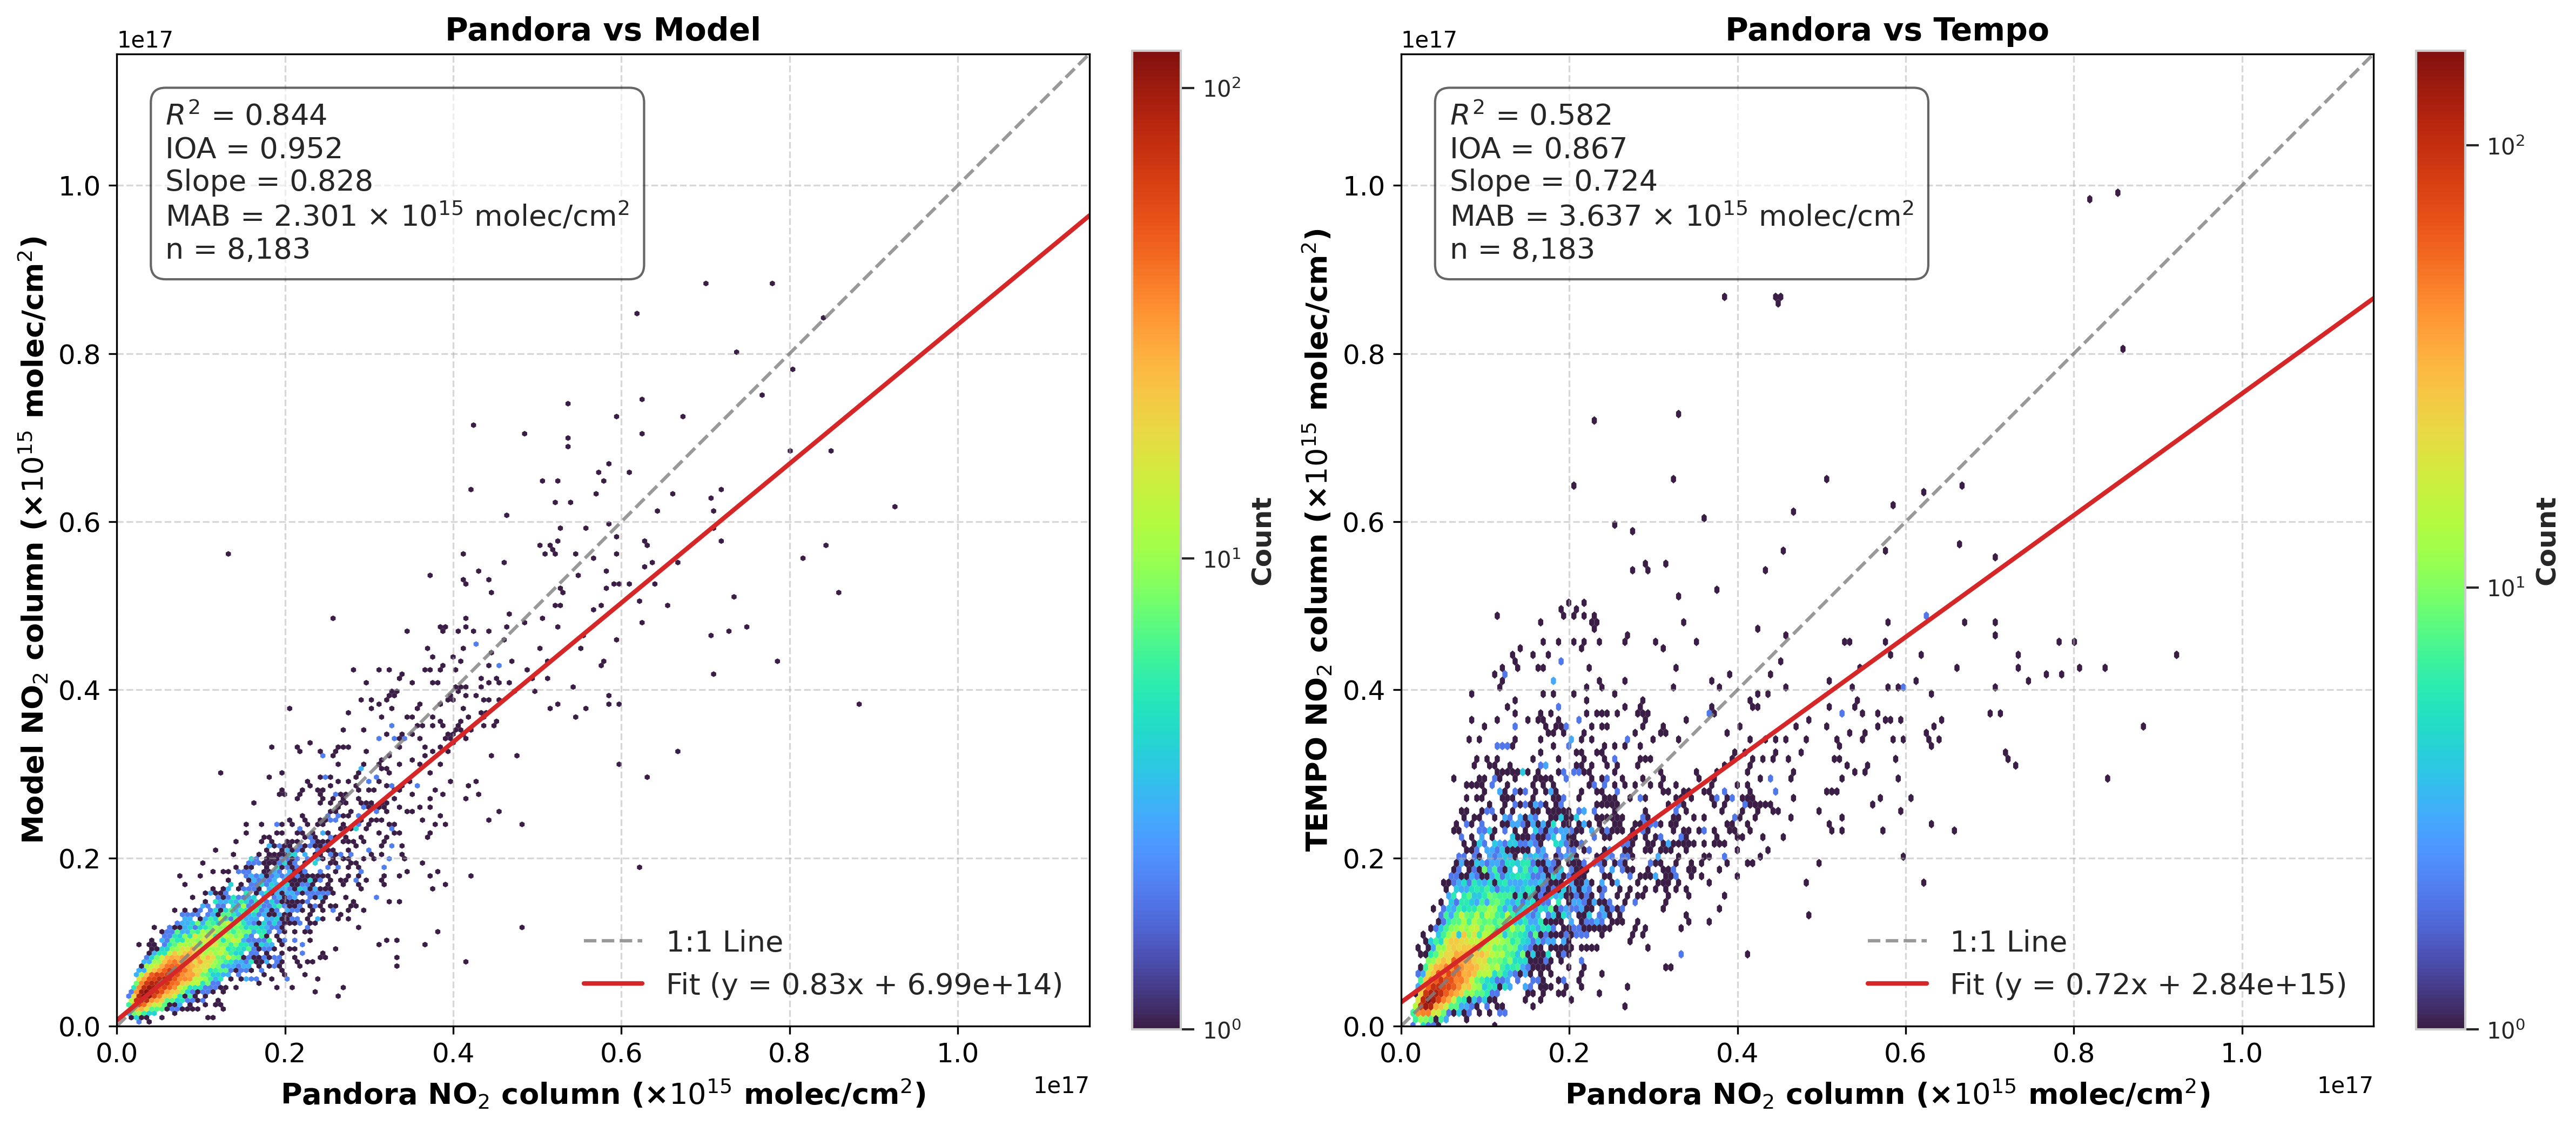

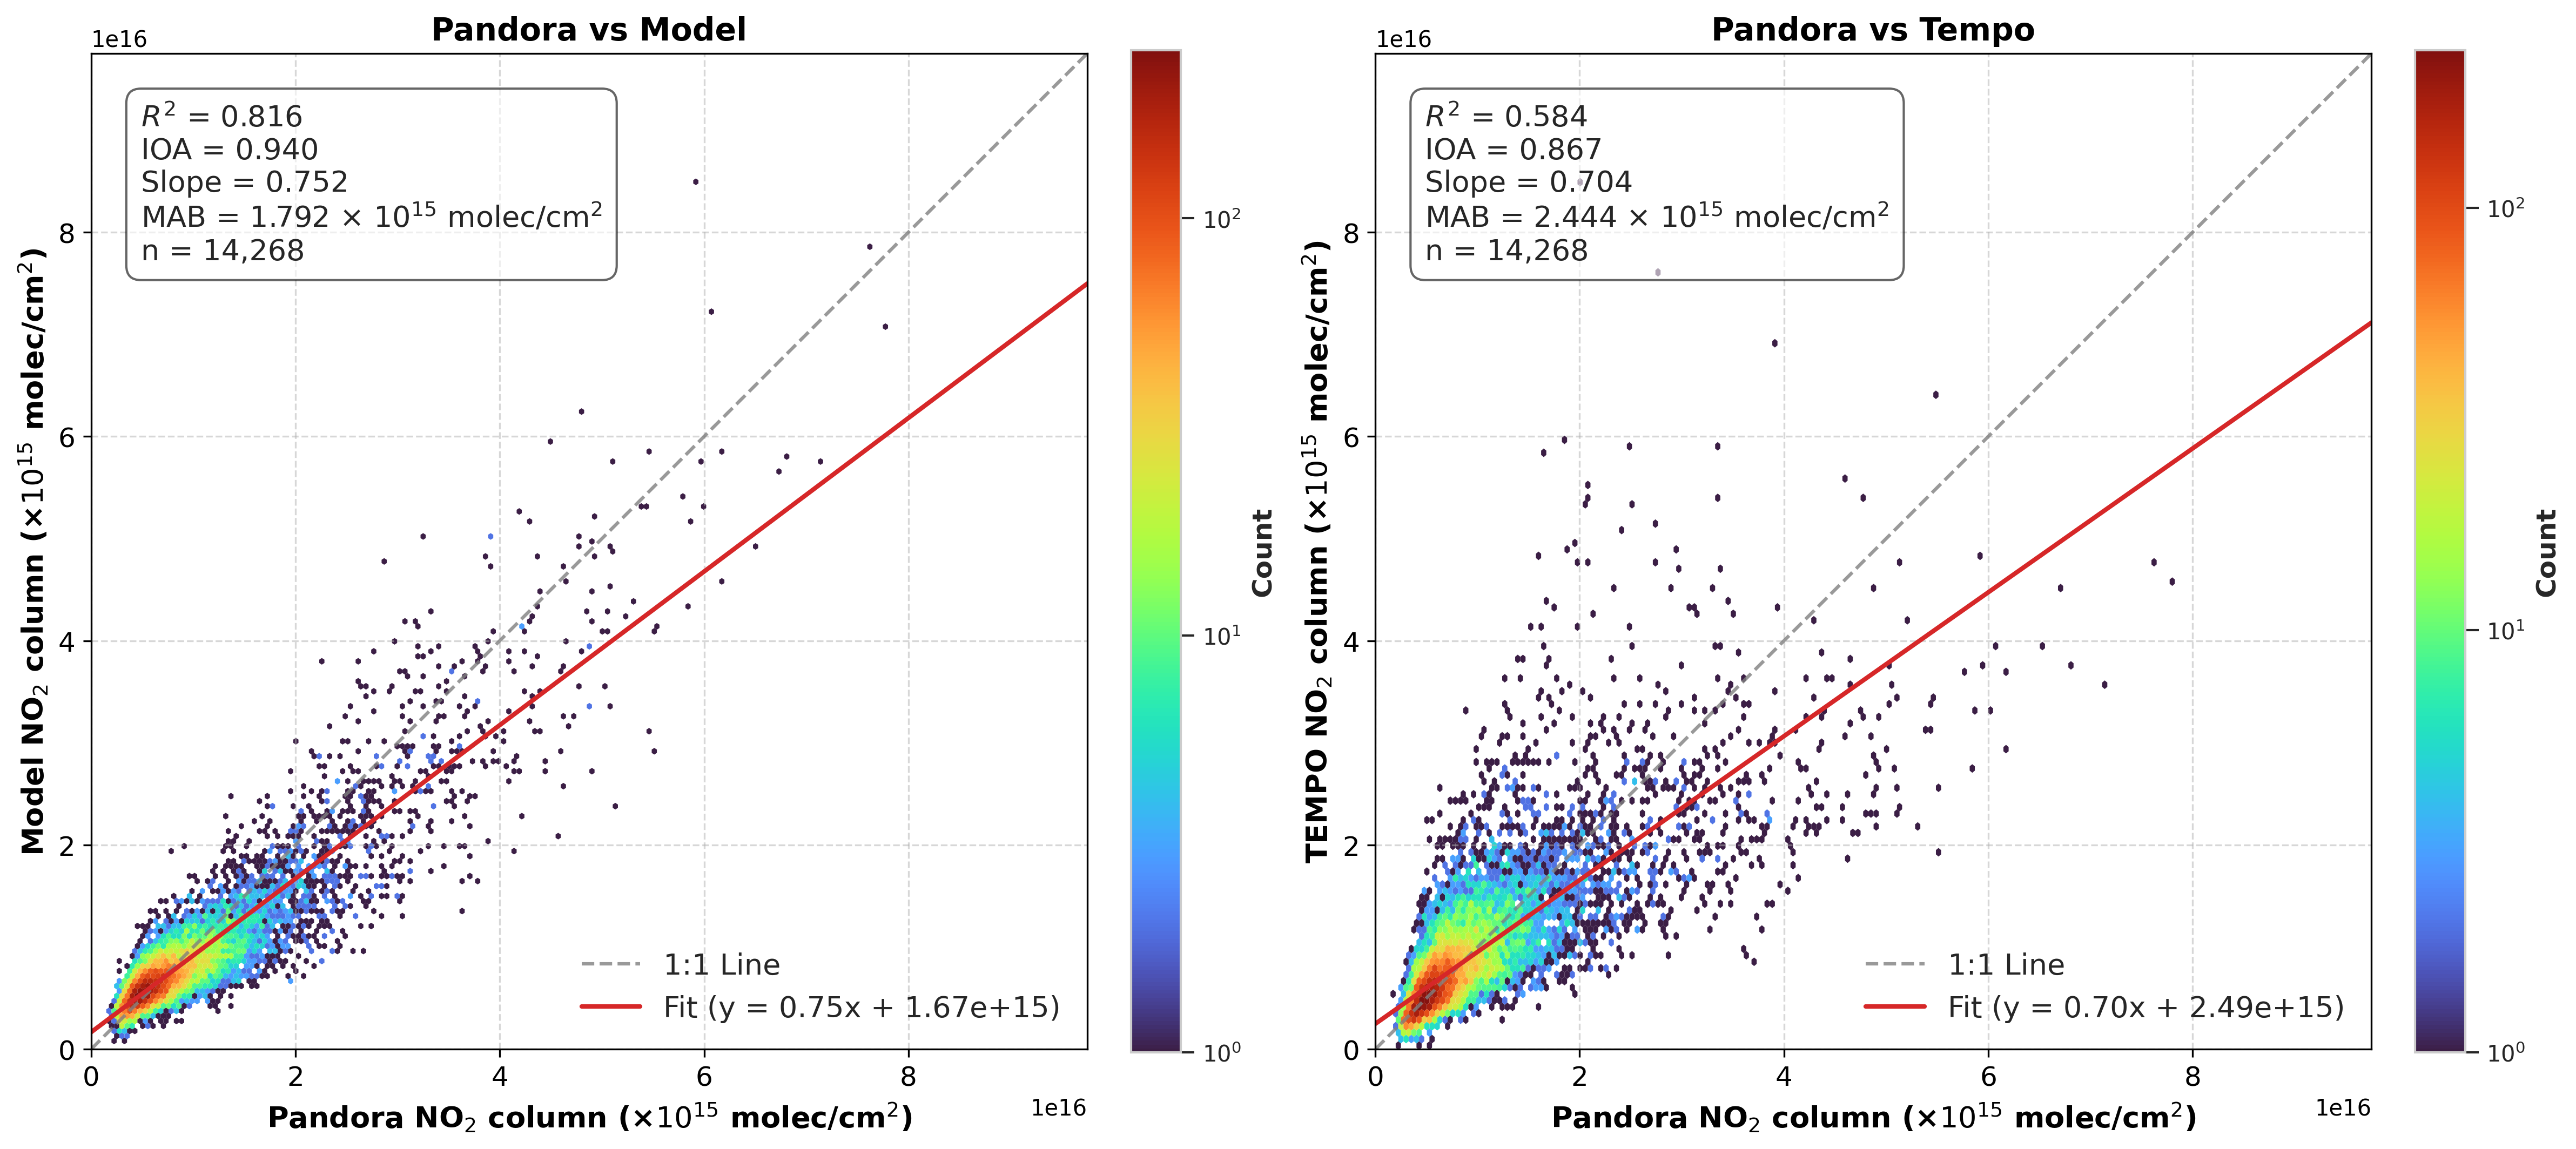

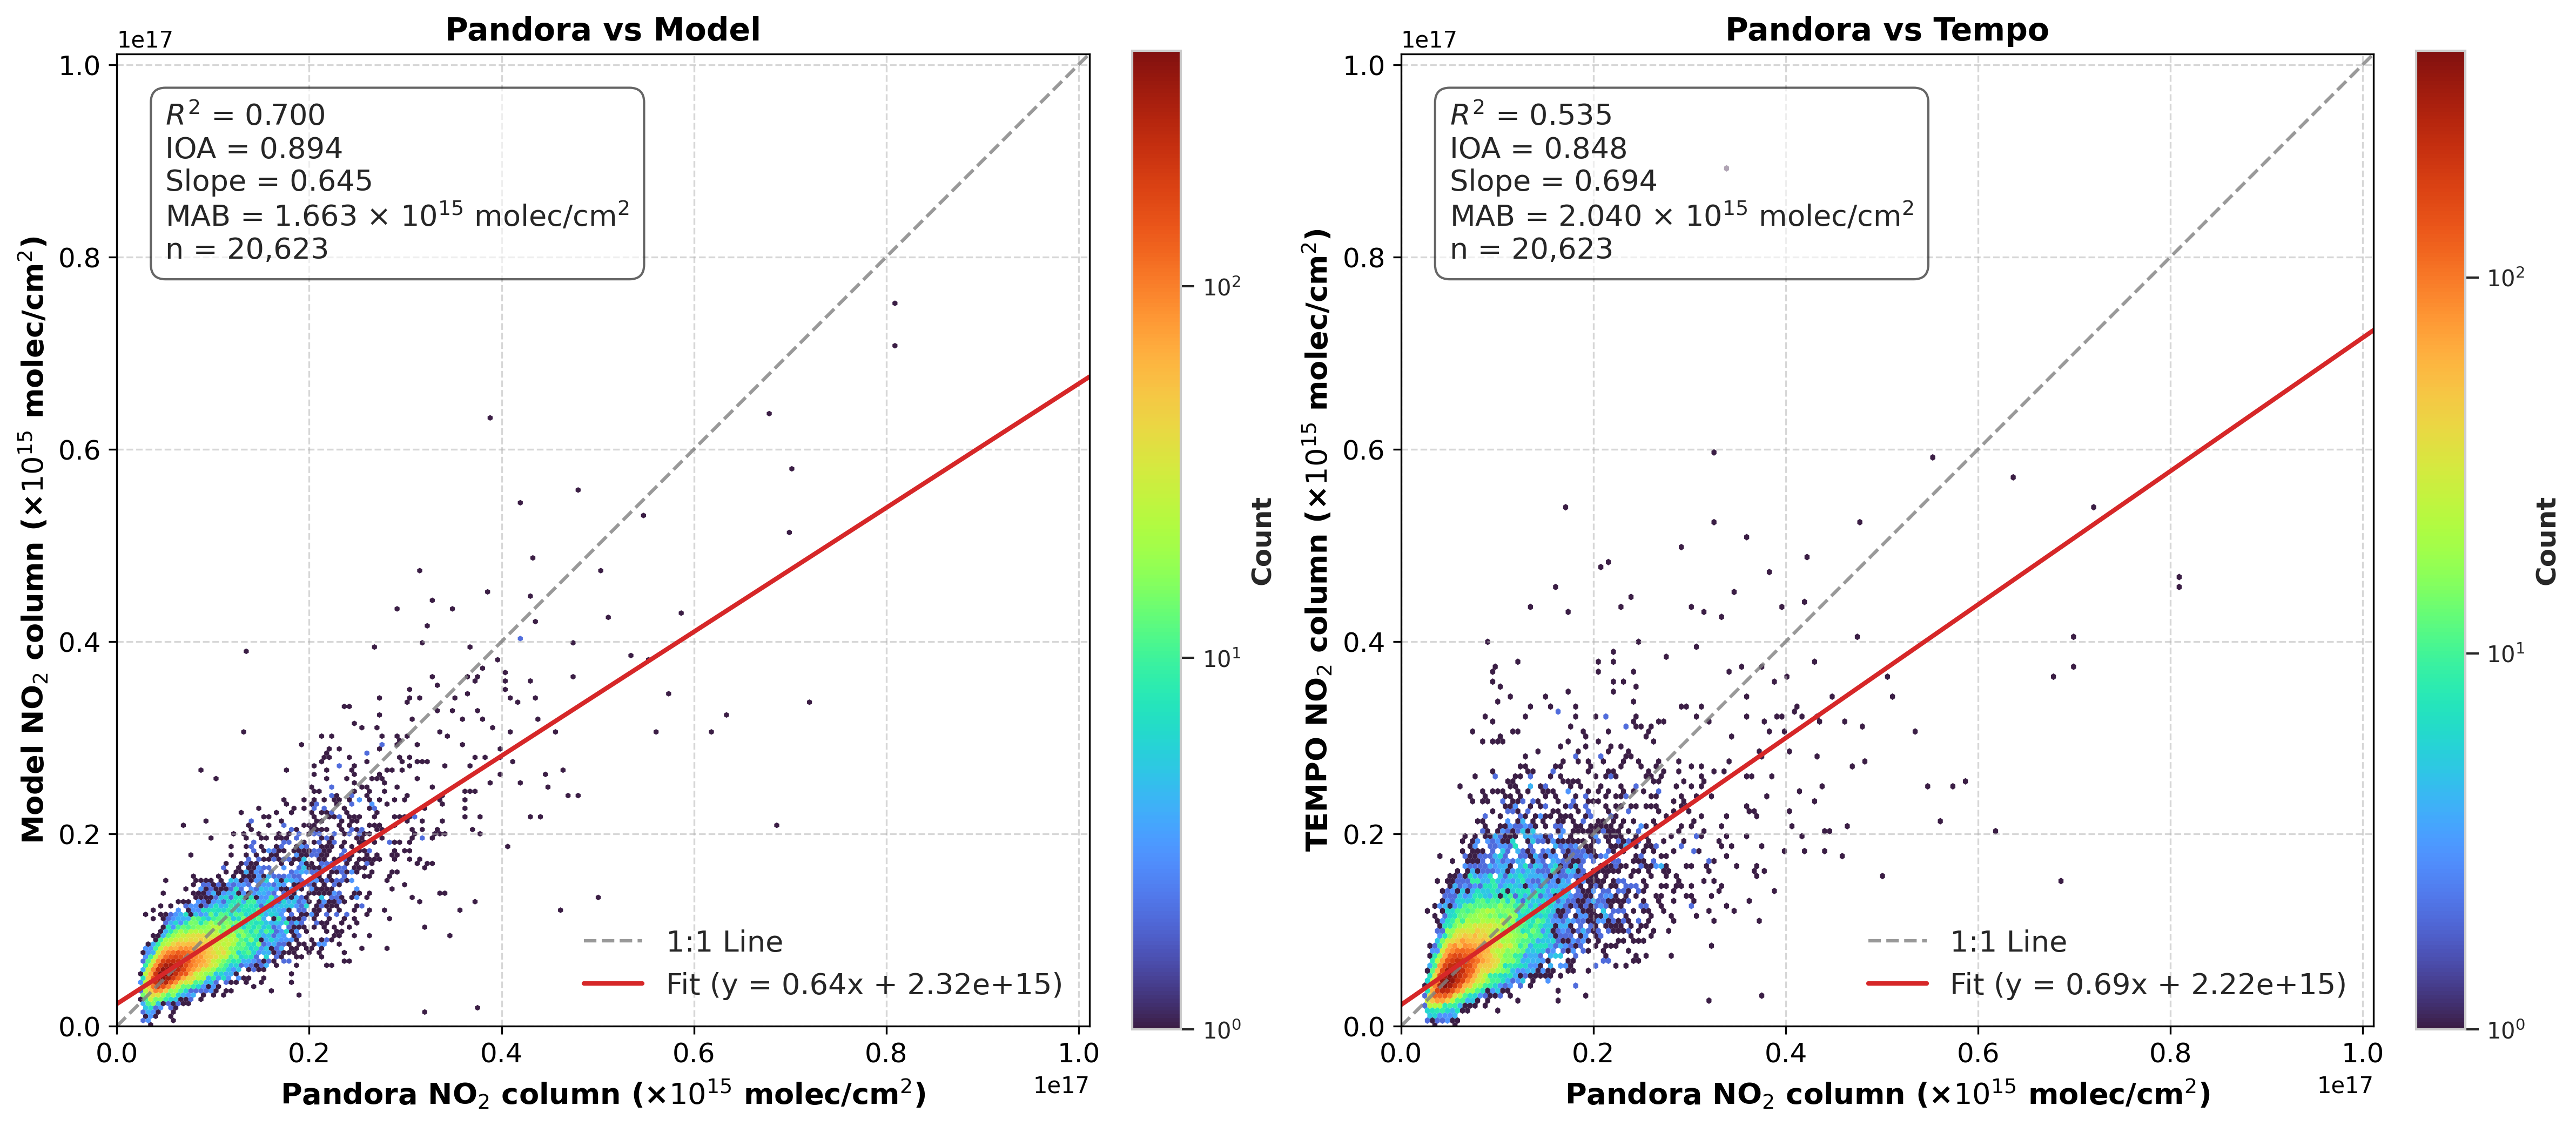

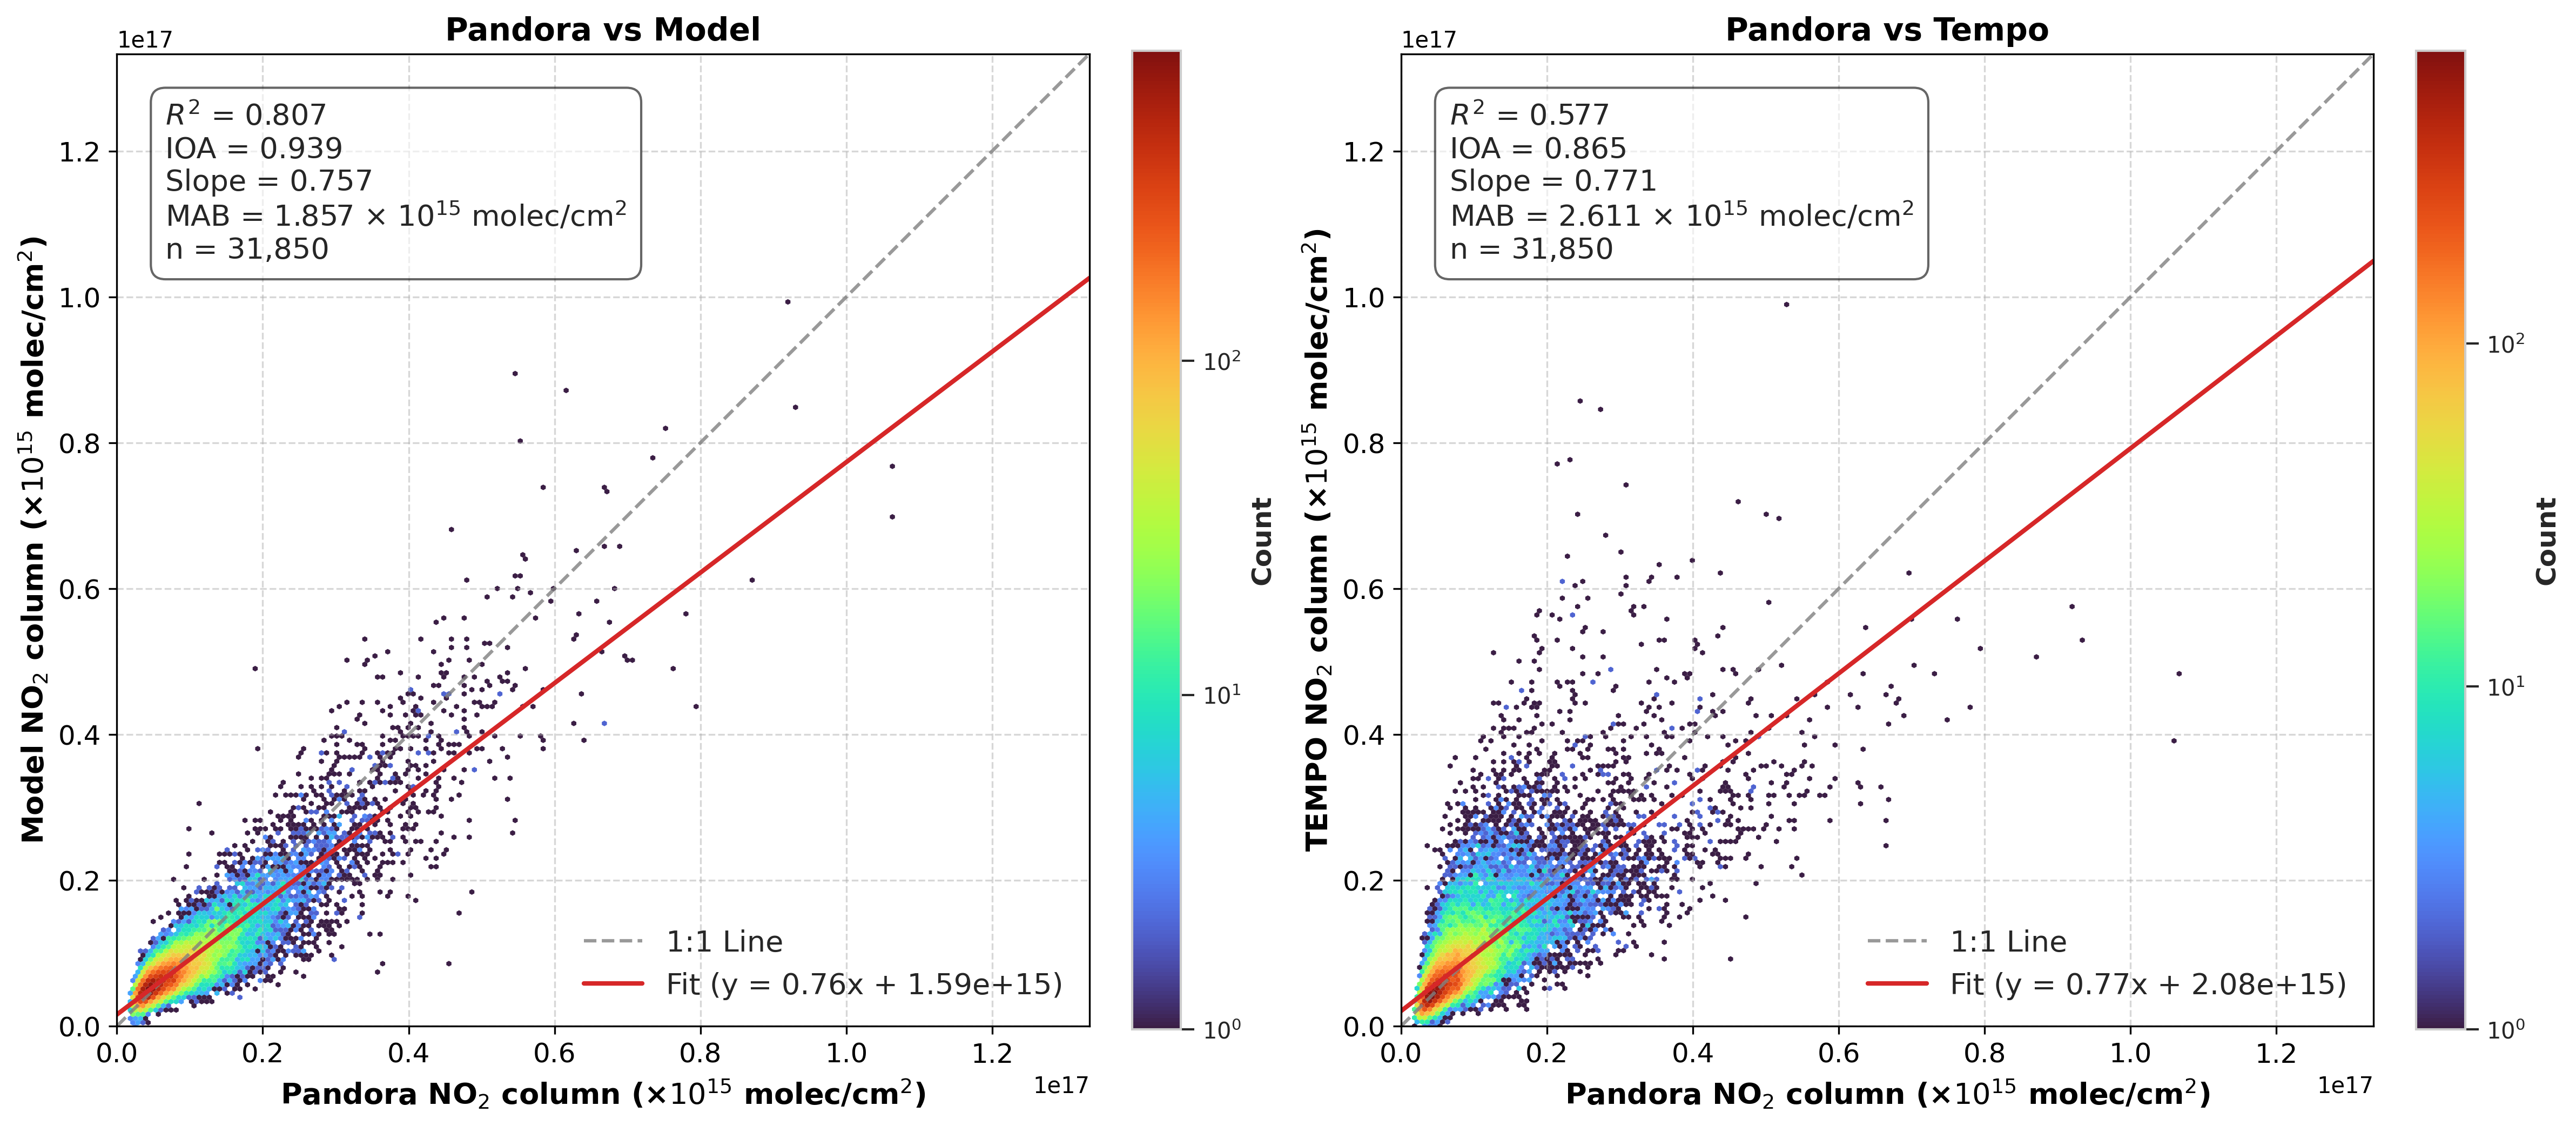

In [4]:
season_metrics = seasonal_results('../runs/albation/K_fold_dates')
season_metrics_df1 = pd.DataFrame(season_metrics).T
season_metrics_df1.to_csv('metrics/season_metrics.csv')

In [5]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# def create_seasonal_comparison_plot(csv_path='season_metrics.csv'):
#     # Load the data
#     df = pd.read_csv(csv_path, index_col=0)
    
#     # Set seaborn style
#     sns.set_theme(style="whitegrid")
    
#     # Create a longer format dataframe for easier seaborn plotting
#     plot_data = []
#     for season in df.index:
#         for metric in ['r2', 'rmse', 'ioa', 'mab']:
#             plot_data.append({'Season': season, 'Metric': metric, 'Type': 'Model', 'Value': df.loc[season, f'{metric}_model']})
#             plot_data.append({'Season': season, 'Metric': metric, 'Type': 'Tempo', 'Value': df.loc[season, f'{metric}_tempo']})
    
#     plot_df = pd.DataFrame(plot_data)
    
#     # Create figure with subplots
#     fig, axes = plt.subplots(2, 2, figsize=(16, 12))
#     # fig.suptitle('Seasonal Performance Metrics Comparison', fontsize=20, y=0.98)
    
#     # Custom color palette
#     palette = {"Model": "#3498db", "Tempo": "#e74c3c"}
    
#     # Plot settings
#     metrics = {'r2': 'R²', 'rmse': 'RMSE', 'ioa': 'IOA', 'mab': 'MAB'}
#     y_labels = {
#         'r2': 'R²', 
#         'rmse': 'RMSE (molec/cm$^2$)', 
#         'ioa': 'IOA', 
#         'mab': 'MAB (molec/cm$^2$)'
#     }
#     positions = {'r2': (0, 0), 'rmse': (0, 1), 'ioa': (1, 0), 'mab': (1, 1)}
#     ylims = {'r2': (0, 1), 'rmse': None, 'ioa': (0, 1), 'mab': None}
    
#     # Create the plots
#     for metric, title in metrics.items():
#         row, col = positions[metric]
#         ax = axes[row, col]
        
#         # Filter data for this metric
#         metric_data = plot_df[plot_df['Metric'] == metric]
        
#         # Plot with seaborn
#         sns.barplot(
#             data=metric_data,
#             x='Season',
#             y='Value',
#             hue='Type',
#             palette=palette,
#             ax=ax,
#             alpha=0.8
#         )
        
#         # Set title and labels
#         # ax.set_title(title, fontsize=16, pad=10)
#         ax.set_xlabel('', fontsize=14)
#         ax.set_ylabel(y_labels[metric], fontsize=14,fontweight='bold')
#         for label in ax.get_xticklabels():
#             label.set_fontweight('bold')
#         # Set y-axis limits if specified
#         if ylims[metric]:
#             ax.set_ylim(ylims[metric])
        
#         # Remove legend from individual subplots
#         ax.get_legend().remove()
    
#     # Add a single legend at the figure level
#     handles, labels = axes[0, 0].get_legend_handles_labels()
#     fig.legend(
#         handles, 
#         labels, 
#         loc='upper center', 
#         bbox_to_anchor=(0.5, 0.94),
#         ncol=2, 
#         fontsize=14, 
#         frameon=True,
#         edgecolor='black'
#     )
    
#     # Adjust layout
#     plt.tight_layout()
#     plt.subplots_adjust(top=0.88, wspace=0.25, hspace=0.3)
    
#     # Return the figure
#     return fig

# # Example usage:
# # my_fig = create_seasonal_comparison_plot()
# my_fig = create_seasonal_comparison_plot(csv_path='fold_metrics/season_metrics.csv')
# my_fig.savefig('season_plot/seasonal_metrics_comparison.png', dpi=300, bbox_inches='tight')


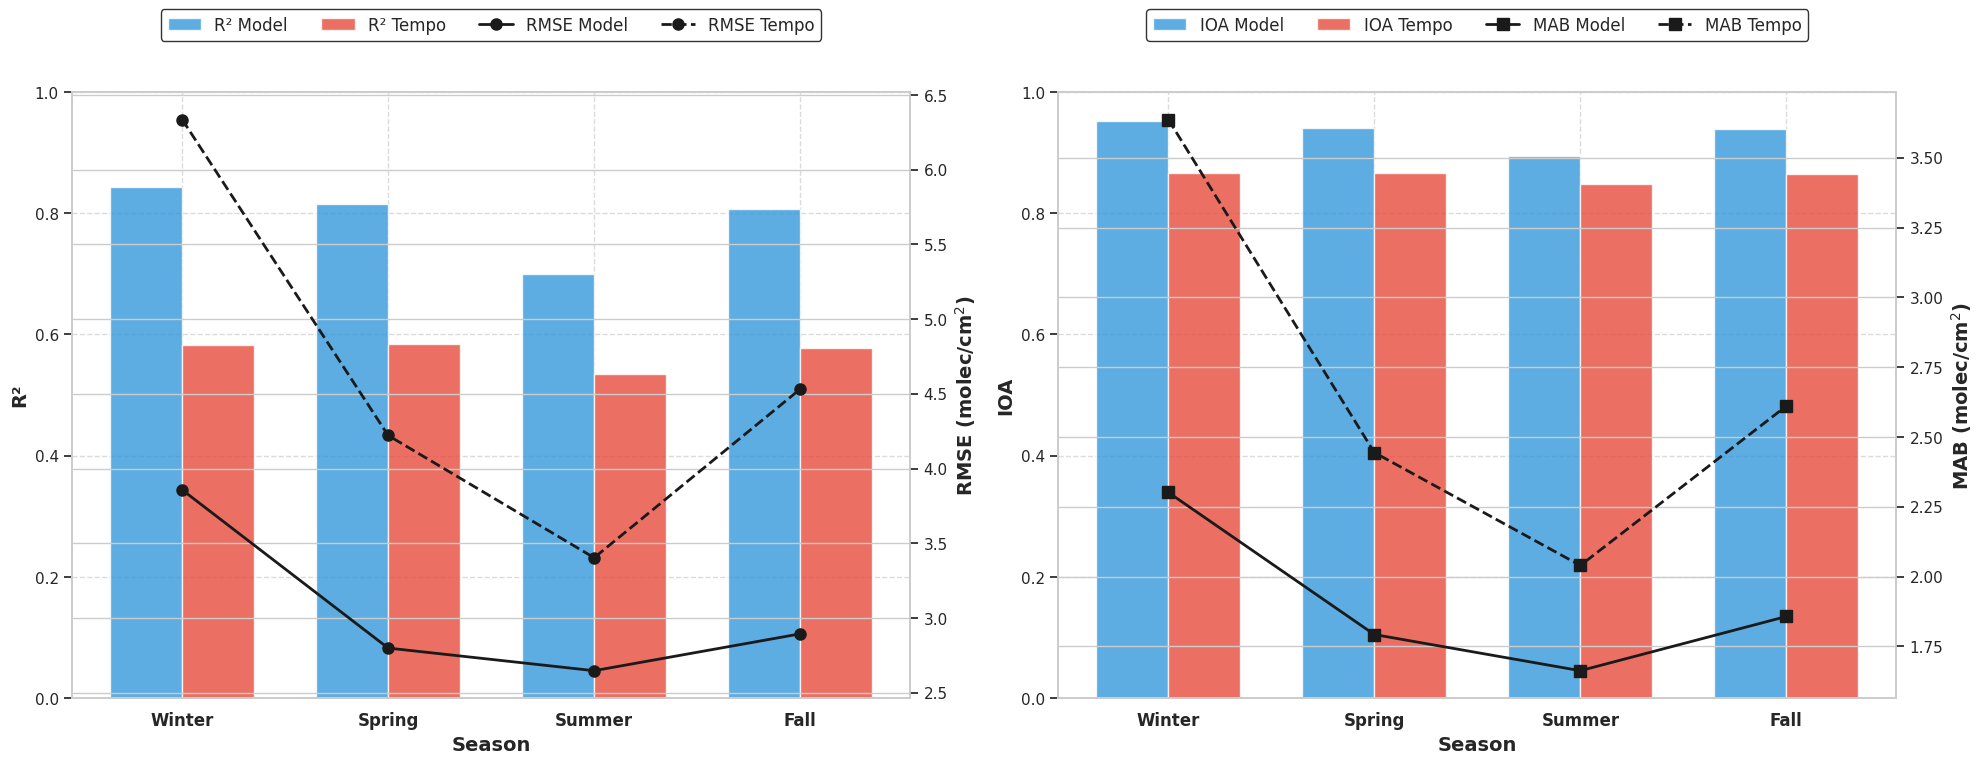

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def create_dual_seasonal_plots(csv_path='season_metrics.csv'):
    # Load the data
    df = pd.read_csv(csv_path, index_col=0)
    
    # Set seaborn style
    sns.set_theme(style="whitegrid")
    
    # Define seasons and x positions
    seasons = df.index.tolist()
    x = np.arange(len(seasons))
    width = 0.35  # Width of the bars
    
    # Custom colors
    model_color = "#3498db"  # Blue for Model
    tempo_color = "#e74c3c"  # Red for Tempo
    line_model_color = "k"  # Black for line (Model)
    line_tempo_color = "k"  # Black for line (Tempo)
    
    # Create figure with two subplots - INCREASED SIZE
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))  # Increased from (20, 8)
    
    # Plot 1: R² (bars) and RMSE (lines)
    # R² bars
    bar1 = ax1.bar(x - width/2, df['r2_model'], width, label='R² Model', color=model_color, alpha=0.8)
    bar2 = ax1.bar(x + width/2, df['r2_tempo'], width, label='R² Tempo', color=tempo_color, alpha=0.8)
    
    # Set primary y-axis (R²) - INCREASED FONT SIZE
    ax1.set_ylabel('R²', fontsize=24, fontweight='bold')  # Increased from 14
    ax1.set_ylim(0, 1)  # R² is between 0 and 1
    ax1.set_xticks(x)
    ax1.set_xticklabels(seasons, fontweight='bold', fontsize=18)  # Increased from 12
    ax1.set_xlabel('Season', fontsize=22, fontweight='bold')  # Increased from 14
    ax1.tick_params(axis='y', labelsize=20)  # Increased tick label size
    
    # Create secondary y-axis for RMSE
    ax1_twin = ax1.twinx()
    
    # RMSE lines - INCREASED LINE WIDTH AND MARKER SIZE
    line1 = ax1_twin.plot(x, df['rmse_model'], 'o-', linewidth=3, markersize=10,  # Increased from 2, 8
                         label='RMSE Model', color=line_model_color)
    line2 = ax1_twin.plot(x, df['rmse_tempo'], 'o--', linewidth=3, markersize=10,  # Increased from 2, 8
                         label='RMSE Tempo', color=line_tempo_color)
    
    # Set secondary y-axis label - INCREASED FONT SIZE
    ax1_twin.set_ylabel('RMSE (molec/cm$^2$)', fontsize=20, fontweight='bold')  # Increased from 14
    ax1_twin.tick_params(axis='y', labelsize=20)  # Increased tick label size
    
    # Add grid
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Combine legends for first plot
    bars1 = [bar1[0], bar2[0]]
    lines1 = [line1[0], line2[0]]
    labels1 = ['R² Model', 'R² Tempo', 'RMSE Model', 'RMSE Tempo']
    
    # Create legend for first plot - INCREASED FONT SIZE
    ax1.legend(bars1 + lines1, labels1, loc='upper center', 
              bbox_to_anchor=(0.5, 1.12), ncol=4, fontsize=20,  # Increased from 12
              frameon=True, edgecolor='black')
    
    # Plot 2: IOA (bars) and MAB (lines)
    # IOA bars
    bar3 = ax2.bar(x - width/2, df['ioa_model'], width, label='IOA Model', color=model_color, alpha=0.8)
    bar4 = ax2.bar(x + width/2, df['ioa_tempo'], width, label='IOA Tempo', color=tempo_color, alpha=0.8)
    
    # Set primary y-axis (IOA) - INCREASED FONT SIZE
    ax2.set_ylabel('IOA', fontsize=24, fontweight='bold')  # Increased from 14
    ax2.set_ylim(0, 1)  # IOA is between 0 and 1
    ax2.set_xticks(x)
    
    ax2.set_xticklabels(seasons, fontweight='bold', fontsize=18)  # Increased from 12
    ax2.set_xlabel('Season', fontsize=22, fontweight='bold')  # Increased from 14
    ax2.tick_params(axis='y', labelsize=20)  # Increased tick label size
    
    
    # Create secondary y-axis for MAB
    ax2_twin = ax2.twinx()
    
    # MAB lines - INCREASED LINE WIDTH AND MARKER SIZE
    line3 = ax2_twin.plot(x, df['mab_model'], 's-', linewidth=3, markersize=10,  # Increased from 2, 8
                         label='MAB Model', color=line_model_color)
    line4 = ax2_twin.plot(x, df['mab_tempo'], 's--', linewidth=3, markersize=10,  # Increased from 2, 8
                         label='MAB Tempo', color=line_tempo_color)
    
    # Set secondary y-axis label - INCREASED FONT SIZE
    ax2_twin.set_ylabel('MAB (molec/cm$^2$)', fontsize=20, fontweight='bold')  # Increased from 14
    ax2_twin.tick_params(axis='y', labelsize=20)  # Increased tick label size
    
    # Add grid
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Combine legends for second plot
    bars2 = [bar3[0], bar4[0]]
    lines2 = [line3[0], line4[0]]
    labels2 = ['IOA Model', 'IOA Tempo', 'MAB Model', 'MAB Tempo']
    
    # Create legend for second plot - INCREASED FONT SIZE
    ax2.legend(bars2 + lines2, labels2, loc='upper center', 
              bbox_to_anchor=(0.5, 1.12), ncol=4, fontsize=20,  # Increased from 12
              frameon=True, edgecolor='black')
    
    # Adjust layout
    plt.tight_layout()
    
    plt.subplots_adjust(top=0.88)  # Adjusted for larger legend
    
    # Return the figure
    return fig

# Example usage:
my_fig = create_dual_seasonal_plots(csv_path='fold_metrics/season_metrics.csv')
my_fig.savefig('Fig_3.png', dpi=300, bbox_inches='tight')